In [1]:
import pysm3
import pysm3.units as u
import astropy.io.fits as fits

import healpy as hp
from fgbuster import (CMB, Dust, Synchrotron,
                      basic_comp_sep,
                      get_observation, get_noise_realization, get_instrument, get_sky)
from fgbuster.visualization import corner_norm


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import sys
sys.path.append('/home/rguidetti')

from PolAngle import *
from beam import * 
from map import *
from convolution import * 
from beam_class import *
from PatchFunctions import *  # nuove funzioni in quanto quelle vecchie lavoravano con mappe NxN. Queste funzionano per mappe rettangolari Nx,Ny

In [2]:
nside = 64

sky = get_sky(nside, 'd1s1')
instrument = get_instrument('LiteBIRD')
freq_maps = get_observation(instrument, sky)

In [3]:
pix_area_deg = hp.pixelfunc.nside2pixarea(nside, degrees=True) # degrees
pix_size_deg = np.sqrt(pix_area_deg) # degrees
pix_size = pix_size_deg *60 #arcmin
pix_size

print(f"With nside = {nside}, the pixel size is {pix_size} arcmin ({pix_size_deg} degrees)")

With nside = 64, the pixel size is 54.96778258907849 arcmin (0.9161297098179748 degrees)


In [4]:
# seleziono solo alcune frequenze per comodità (8 su 15) 

mappa40  = freq_maps[0, :, :]
mappa60  = freq_maps[2, :, :]
mappa78  = freq_maps[4, :, :]
mappa100 = freq_maps[6, :, :]
mappa140 = freq_maps[8, :, :]
mappa195 = freq_maps[10, :, :]
mappa280 = freq_maps[12, :, :]
mappa402 = freq_maps[14, :, :]


##############################################################

I40 = mappa40[0,:]
Q40 = mappa40[1,:]
U40 = mappa40[2,:]

I60 = mappa60[0,:]
Q60 = mappa60[1,:]
U60 = mappa60[2,:]

I78 = mappa78[0,:]
Q78 = mappa78[1,:]
U78 = mappa78[2,:]

I100 = mappa100[0,:]
Q100 = mappa100[1,:]
U100 = mappa100[2,:]

I140 = mappa140[0,:]
Q140 = mappa140[1,:]
U140 = mappa140[2,:]

I195 = mappa195[0,:]
Q195 = mappa195[1,:]
U195 = mappa195[2,:]

I280 = mappa280[0,:]
Q280 = mappa280[1,:]
U280 = mappa280[2,:]

I402 = mappa402[0,:]
Q402 = mappa402[1,:]
U402 = mappa402[2,:]

np.shape(I40)

(49152,)

In [5]:
def create_rectangular_patch(RA_limits, DEC_limits, nside, fact = 3):

    '''
    Create a rectangular patch in a healpix map
    Parameters:
    RA_limits: array or list with the edges of the map along the RA axis
    DEC_limits: array or list with the edges of the map along the DEC axis
    nside: nside of the map
    fact: just a factor to increase the resolution to be sure all the pixels in patch
          are extracted
    '''

    resol = (hp.nside2resol(nside, arcmin=True) / 60.) / fact

    RA = np.radians(np.arange(RA_limits[0], RA_limits[1] + resol, resol))
    DEC = np.radians(np.arange(DEC_limits[0], DEC_limits[1] + resol, resol))
    
    DEC = 0.5 * np.pi - DEC
    
    theta, phi = np.meshgrid(RA, DEC)

    idx = hp.ang2pix(nside, phi, theta)

    return np.unique(idx), resol * fact


###################################################################################################
# patch
RA1 = -60 
RA2 = 60
dec1 = -70
dec2 = -40
idxs, resol = create_rectangular_patch([RA1, RA2], [dec1, dec2], nside)

map_array= [I40, Q40, U40, 
            I60, Q60, U60, 
            I78, Q78, U78, 
            I100, Q100, U100, 
            I140, Q140, U140, 
            I195, Q195, U195, 
            I280, Q280, U280, 
            I402, Q402, U402 ]


for map in map_array:

    visualize_patch = map.copy()

    mask = np.zeros_like(visualize_patch, dtype=bool)
    mask[idxs] = True

    visualize_patch[~mask] = hp.UNSEEN

    map[~mask] = 0.0

# patch 2d

In [6]:
from functools import partial
from scipy.interpolate import griddata
from skimage.restoration import inpaint


def convert2grid(map, nside, resol, RA, DEC, method='healpy', scipy_method='linear', fill_nan=True):

    xsize = int(np.ceil(np.abs(np.ptp(RA))/resol))
    ysize = int(np.ceil(np.abs(np.ptp(DEC))/resol))

    if method == 'healpy':
        proj = hp.projector.CartesianProj(
            lonra=[RA1, RA2], latra=[dec1, dec2],
            coord='G',
            xsize=xsize, ysize=ysize)

        reproj_map = np.flip(
            (proj.projmap(map, vec2pix_func=partial(hp.vec2pix, nside))),
            axis=1)

        extent = proj.get_extent()

        ra = np.linspace(extent[0], extent[1], xsize)
        dec = np.linspace(extent[2], extent[3], ysize)

        ra, dec = np.meshgrid(ra, dec)
        
        reproj_map[reproj_map==0]=np.nan

    elif method == 'scipy':
        
        npix = hp.nside2npix(nside)

        ra_full, dec_full = hp.pix2ang(
            nside,
            np.arange(npix),
            lonlat = True
        )

        ra_full[ra_full > 180] -= 360

        idxs, = np.where(map != 0)

        ra, dec = hp.pix2ang(nside, idxs, lonlat=True)

        ra[ra > 180] -= 360

        ra_in = np.arange(np.amin(ra), np.amax(ra)+resol, resol)
        dec_in = np.arange(np.amin(dec), np.amax(dec)+resol, resol)

        ra, dec = np.meshgrid(ra_in, dec_in)

        reproj_map = griddata((ra_full, dec_full), map, (ra, dec), method=scipy_method)

    if fill_nan:
        reproj_map = inpaint.inpaint_biharmonic(reproj_map, np.isnan(reproj_map))

    return reproj_map, ra.flatten(), dec.flatten()



#######################################################################################################
maps_2d = {}
extent=(RA1, RA2, dec1, dec2)

bands = ['40', '60', '78', '100', '140', '195', '280', '402']
types = ['I', 'Q', 'U']


for band in bands:
    for map_type in types:
        map_name = f"{map_type}{band}"
        map_data = globals()[map_name]
        variable_prefix = f"{map_type}{band}"
        
        mp_hp, ra_hp, dec_hp = convert2grid(map_data, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
        
        maps_2d[f"mp_hp_{variable_prefix}"] = mp_hp
        maps_2d[f"ra_hp_{variable_prefix}"] = ra_hp
        maps_2d[f"dec_hp_{variable_prefix}"] = dec_hp
        #print(f"Stored variables for: {variable_prefix}") 


### Dimensioni mappe

In [7]:
Ny, Nx = np.shape(maps_2d['mp_hp_I40']) 
print(Nx, Ny)

X_width = Nx * pix_size/60
Y_width = Ny * pix_size/60

# color map
c_min, c_max     = -10, 10  

393 99


### Beam

In [8]:
# COORDINATES LIKE THE ONES OF THE MAPS

Nx = int(Nx)
Ny = int(Ny)

onesx = np.ones(Nx)
onesy = np.ones(Ny)

indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size
indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size

#X = np.outer(onesy, indsx)
#Y = np.outer(indsy, onesx)
X = np.outer(onesy, indsx)
Y = np.outer(indsy, onesx)
R = np.sqrt(X**2. + Y**2.)



# VARIABLES

FWHM_x = 40  #degrees
FWHM_y = 60  #degrees
ellipticity = (FWHM_x - FWHM_y) / (FWHM_x + FWHM_y)
print("ellipticity = ", ellipticity)

array_dB = np.array([-20, -22, -24, -26]) #max values of the secondary peaks
array_dB = array_dB * 2.5
r1 = np.array([80000, 200000, 300000, 400000]) #angular distance of the peaks
r = 100 # width of the rings

theta = 0 # angle of rotation of the beam
a = 1 # major axis of ellipses 


# BEAM

beam_gauss_x, beam_gauss_y, sec_rings_x,sec_rings_y, beam_x, beam_y = create_beam_secpeaks(pix_size, FWHM_x, FWHM_y, theta, array_dB, r, r1, X, Y, a, ellipticity)

########################################################################################

### beam systematics dictionary
bs = {"budy":{"A":1e-3,"FWHP":105.5,"R":2000.,"psi":0.3,"polfracQ":0.5,"polfracU":0.01},  
                                                                         # little budy amplitude, 
                                                                         #FWHP, offset spacing, rotationa angle (radians)
                                                                        # pol_fraction for Q and U
     "ghostshelf": {"A":1e-4,"Diam":200.,"roll_off":7.},    #model of ghosting, amplitude (A), diameter (Diam) 
     "hex_crostalk":{"grid_space": 100.,"N":1,"neighbor_exp_fall":0.01}, 
                                                                               ## model of optical cross talk 
                                                                               ## to detectors on a hex grid
                                                                               ## assumed to be exponetial
                                                                               ## assumed to be 50% polarized
      "TtoQ":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
      "TtoU":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
                                                                  ## multiplole expansion leakage
      'psi':0.01*np.pi/180.
                                  ## detetor angle rotations
                   }

beam_sys = BeamSystematics()
beam_TT, beam_QQ, beam_UU, beam_QT, beam_UT, beam_QU, beam_UQ = make_systematics_beams_r(Nx, Ny, pix_size, FWHM_x, beam_x, bs)


#######################################################################################################################à

# convolution with perfect beam
perf_beam, no1, no2, no3, no4, no5 = create_beam_secpeaks(pix_size, FWHM_x, FWHM_y, 0, array_dB, r, r1, X, Y, a, ellipticity)
perf_beam = perf_beam / np.sum(perf_beam)

Q_conv_perf_40 = convolve_map_with_beam(maps_2d['mp_hp_Q40'], perf_beam)
U_conv_perf_40 = convolve_map_with_beam(maps_2d['mp_hp_U40'], perf_beam)

Q_conv_perf_60 = convolve_map_with_beam(maps_2d['mp_hp_Q60'], perf_beam)
U_conv_perf_60 = convolve_map_with_beam(maps_2d['mp_hp_U60'], perf_beam)

Q_conv_perf_78 = convolve_map_with_beam(maps_2d['mp_hp_Q78'], perf_beam)
U_conv_perf_78 = convolve_map_with_beam(maps_2d['mp_hp_U78'], perf_beam)

Q_conv_perf_100 = convolve_map_with_beam(maps_2d['mp_hp_Q100'], perf_beam)
U_conv_perf_100 = convolve_map_with_beam(maps_2d['mp_hp_U100'], perf_beam)

Q_conv_perf_140 = convolve_map_with_beam(maps_2d['mp_hp_Q140'], perf_beam)
U_conv_perf_140 = convolve_map_with_beam(maps_2d['mp_hp_U140'], perf_beam)

Q_conv_perf_195 = convolve_map_with_beam(maps_2d['mp_hp_Q195'], perf_beam)
U_conv_perf_195 = convolve_map_with_beam(maps_2d['mp_hp_U195'], perf_beam)

Q_conv_perf_280 = convolve_map_with_beam(maps_2d['mp_hp_Q280'], perf_beam)
U_conv_perf_280 = convolve_map_with_beam(maps_2d['mp_hp_U280'], perf_beam)

Q_conv_perf_402 = convolve_map_with_beam(maps_2d['mp_hp_Q402'], perf_beam)
U_conv_perf_402 = convolve_map_with_beam(maps_2d['mp_hp_U402'], perf_beam)



# convolution with real beam
I_conv_real_40 = convolve_map_with_beam(maps_2d['mp_hp_I40'], beam_TT)
Q_conv_real_40 = convolve_map_with_beam(maps_2d['mp_hp_Q40'], beam_QQ)
U_conv_real_40 = convolve_map_with_beam(maps_2d['mp_hp_U40'], beam_UU)

I_conv_real_60 = convolve_map_with_beam(maps_2d['mp_hp_I60'], beam_TT)
Q_conv_real_60 = convolve_map_with_beam(maps_2d['mp_hp_Q60'], beam_QQ)
U_conv_real_60 = convolve_map_with_beam(maps_2d['mp_hp_U60'], beam_UU)

I_conv_real_78 = convolve_map_with_beam(maps_2d['mp_hp_I78'], beam_TT)
Q_conv_real_78 = convolve_map_with_beam(maps_2d['mp_hp_Q78'], beam_QQ)
U_conv_real_78 = convolve_map_with_beam(maps_2d['mp_hp_U78'], beam_UU)

I_conv_real_100 = convolve_map_with_beam(maps_2d['mp_hp_I100'], beam_TT)
Q_conv_real_100 = convolve_map_with_beam(maps_2d['mp_hp_Q100'], beam_QQ)
U_conv_real_100 = convolve_map_with_beam(maps_2d['mp_hp_U100'], beam_UU)

I_conv_real_140 = convolve_map_with_beam(maps_2d['mp_hp_I140'], beam_TT)
Q_conv_real_140 = convolve_map_with_beam(maps_2d['mp_hp_Q140'], beam_QQ)
U_conv_real_140 = convolve_map_with_beam(maps_2d['mp_hp_U140'], beam_UU)

I_conv_real_195 = convolve_map_with_beam(maps_2d['mp_hp_I195'], beam_TT)
Q_conv_real_195 = convolve_map_with_beam(maps_2d['mp_hp_Q195'], beam_QQ)
U_conv_real_195 = convolve_map_with_beam(maps_2d['mp_hp_U195'], beam_UU)

I_conv_real_280 = convolve_map_with_beam(maps_2d['mp_hp_I280'], beam_TT)
Q_conv_real_280 = convolve_map_with_beam(maps_2d['mp_hp_Q280'], beam_QQ)
U_conv_real_280 = convolve_map_with_beam(maps_2d['mp_hp_U280'], beam_UU)

I_conv_real_402 = convolve_map_with_beam(maps_2d['mp_hp_I402'], beam_TT)
Q_conv_real_402 = convolve_map_with_beam(maps_2d['mp_hp_Q402'], beam_QQ)
U_conv_real_402 = convolve_map_with_beam(maps_2d['mp_hp_U402'], beam_UU)

ellipticity =  -0.2


### Pol angle

In [9]:
std_deviation_degree = [1., 2., 3.]
std_deviation_rad = np.ones_like((std_deviation_degree))

for i in range(len(std_deviation_degree)):
    std_deviation_rad[i]    = std_deviation_degree[i] * np.pi / 180
    
gauss_center  = 0

print(std_deviation_rad)

[0.01745329 0.03490659 0.05235988]


In [10]:
Q_pert40_1, U_pert40_1   = polangle_map(Q_conv_real_40, U_conv_real_40, gauss_center, std_deviation_rad[0])
Q_pert60_1, U_pert60_1   = polangle_map(Q_conv_real_60, U_conv_real_60, gauss_center, std_deviation_rad[0])
Q_pert78_1, U_pert78_1   = polangle_map(Q_conv_real_78, U_conv_real_78, gauss_center, std_deviation_rad[0])
Q_pert100_1, U_pert100_1 = polangle_map(Q_conv_real_100, U_conv_real_100, gauss_center, std_deviation_rad[0])
Q_pert140_1, U_pert140_1 = polangle_map(Q_conv_real_140, U_conv_real_140, gauss_center, std_deviation_rad[0])
Q_pert195_1, U_pert195_1 = polangle_map(Q_conv_real_195, U_conv_real_195, gauss_center, std_deviation_rad[0])
Q_pert280_1, U_pert280_1 = polangle_map(Q_conv_real_280, U_conv_real_280, gauss_center, std_deviation_rad[0])
Q_pert402_1, U_pert402_1 = polangle_map(Q_conv_real_402, U_conv_real_402, gauss_center, std_deviation_rad[0])


Q_pert40_2, U_pert40_2   = polangle_map(Q_conv_real_40, U_conv_real_40, gauss_center, std_deviation_rad[1])
Q_pert60_2, U_pert60_2   = polangle_map(Q_conv_real_60, U_conv_real_60, gauss_center, std_deviation_rad[1])
Q_pert78_2, U_pert78_2   = polangle_map(Q_conv_real_78, U_conv_real_78, gauss_center, std_deviation_rad[1])
Q_pert100_2, U_pert100_2 = polangle_map(Q_conv_real_100, U_conv_real_100, gauss_center, std_deviation_rad[1])
Q_pert140_2, U_pert140_2 = polangle_map(Q_conv_real_140, U_conv_real_140, gauss_center, std_deviation_rad[1])
Q_pert195_2, U_pert195_2 = polangle_map(Q_conv_real_195, U_conv_real_195, gauss_center, std_deviation_rad[1])
Q_pert280_2, U_pert280_2 = polangle_map(Q_conv_real_280, U_conv_real_280, gauss_center, std_deviation_rad[1])
Q_pert402_2, U_pert402_2 = polangle_map(Q_conv_real_402, U_conv_real_402, gauss_center, std_deviation_rad[1])



Q_pert40_3, U_pert40_3   = polangle_map(Q_conv_real_40, U_conv_real_40, gauss_center, std_deviation_rad[2])
Q_pert60_3, U_pert60_3   = polangle_map(Q_conv_real_60, U_conv_real_60, gauss_center, std_deviation_rad[2])
Q_pert78_3, U_pert78_3   = polangle_map(Q_conv_real_78, U_conv_real_78, gauss_center, std_deviation_rad[2])
Q_pert100_3, U_pert100_3 = polangle_map(Q_conv_real_100, U_conv_real_100, gauss_center, std_deviation_rad[2])
Q_pert140_3, U_pert140_3 = polangle_map(Q_conv_real_140, U_conv_real_140, gauss_center, std_deviation_rad[2])
Q_pert195_3, U_pert195_3 = polangle_map(Q_conv_real_195, U_conv_real_195, gauss_center, std_deviation_rad[2])
Q_pert280_3, U_pert280_3 = polangle_map(Q_conv_real_280, U_conv_real_280, gauss_center, std_deviation_rad[2])
Q_pert402_3, U_pert402_3 = polangle_map(Q_conv_real_402, U_conv_real_402, gauss_center, std_deviation_rad[2])



### Apodizzazione

In [11]:
def cosine_window_r(Nx, Ny, x_range=None, y_range=None):
    "Generates a cosine window for apodizing within specified ranges to avoid edge effects in the 2D FFT"
    # Default ranges
    if x_range is None:
        x_range = [-np.pi / 2, np.pi / 2]
    if y_range is None:
        y_range = [-np.pi / 2, np.pi / 2]
    
    # Make a 2D coordinate system within specified ranges
    x_vals = np.linspace(x_range[0], x_range[1], Nx)
    y_vals = np.linspace(y_range[0], y_range[1], Ny)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Make a window map
    window_map = np.cos(X) * np.cos(Y)

    # Return the window map
    return window_map

###########################################################
window = (cosine_window_r(Nx, Ny, x_range=[-np.pi / 4, np.pi / 4], y_range=[-np.pi / 4, np.pi / 4]))


I_ap40 = window * I_conv_real_40
I_ap60 = window * I_conv_real_60
I_ap78 = window * I_conv_real_78
I_ap100 = window * I_conv_real_100
I_ap140 = window * I_conv_real_140
I_ap195 = window * I_conv_real_195
I_ap280 = window * I_conv_real_280
I_ap402 = window * I_conv_real_402

Q_ap40_1 = window * Q_pert40_1
U_ap40_1 = window * U_pert40_1
Q_ap60_1 = window * Q_pert60_1
U_ap60_1 = window * U_pert60_1
Q_ap78_1 = window * Q_pert78_1
U_ap78_1 = window * U_pert78_1
Q_ap100_1 = window * Q_pert100_1
U_ap100_1 = window * U_pert100_1
Q_ap140_1 = window * Q_pert140_1
U_ap140_1 = window * U_pert140_1
Q_ap195_1 = window * Q_pert195_1
U_ap195_1 = window * U_pert195_1
Q_ap280_1 = window * Q_pert280_1
U_ap280_1 = window * U_pert280_1
Q_ap402_1 = window * Q_pert402_1
U_ap402_1 = window * U_pert402_1

Q_ap40_2 = window * Q_pert40_2
U_ap40_2 = window * U_pert40_2
Q_ap60_2 = window * Q_pert60_2
U_ap60_2 = window * U_pert60_2
Q_ap78_2 = window * Q_pert78_2
U_ap78_2 = window * U_pert78_2
Q_ap100_2 = window * Q_pert100_2
U_ap100_2 = window * U_pert100_2
Q_ap140_2 = window * Q_pert140_2
U_ap140_2 = window * U_pert140_2
Q_ap195_2 = window * Q_pert195_2
U_ap195_2 = window * U_pert195_2
Q_ap280_2 = window * Q_pert280_2
U_ap280_2 = window * U_pert280_2
Q_ap402_2 = window * Q_pert402_2
U_ap402_2 = window * U_pert402_2


Q_ap40_3 = window * Q_pert40_3
U_ap40_3 = window * U_pert40_3
Q_ap60_3 = window * Q_pert60_3
U_ap60_3 = window * U_pert60_3
Q_ap78_3 = window * Q_pert78_3
U_ap78_3 = window * U_pert78_3
Q_ap100_3 = window * Q_pert100_3
U_ap100_3 = window * U_pert100_3
Q_ap140_3 = window * Q_pert140_3
U_ap140_3 = window * U_pert140_3
Q_ap195_3 = window * Q_pert195_3
U_ap195_3 = window * U_pert195_3
Q_ap280_3 = window * Q_pert280_3
U_ap280_3 = window * U_pert280_3
Q_ap402_3 = window * Q_pert402_3
U_ap402_3 = window * U_pert402_3


### PS
Voglio vedere gli effetti dei diversi angoli di polarizzazione sul power spectrum. Mi serve però un'unica mappa per I, una per Q e una per U, quindi devo fare la component separation , ma prima devo rasormare in 1D

In [12]:
import pymaster as nmt

In [13]:
idx = hp.ang2pix(nside, ra_hp, dec_hp, lonlat=True)
types={'Q','U'}


flat_I = {}
for band in bands:
    for map_type in types:
        map_name = f"I_ap{band}"
        map_data = globals()[map_name]
        variable_prefix = f"I_ap{band}"
        
        new_map = np.zeros_like(I40)
        new_map[idx] = map_data.flatten()
        
        flat_I[f"I_flat{band}"] = new_map
        #print(f"Stored variables for: {variable_prefix}") 

flat_I.keys()



flat_QU_1 = {}
for band in bands:
    for map_type in types:
        map_name = f"{map_type}_ap{band}_1"
        map_data = globals()[map_name]
        variable_prefix = f"{map_type}_ap{band}_1"
        
        new_map = np.zeros_like(I40)
        new_map[idx] = map_data.flatten()
        
        flat_QU_1[f"{map_type}_flat{band}"] = new_map
        #print(f"Stored variables for: {variable_prefix}") 

flat_QU_1.keys()

#######################################################################

flat_QU_2 = {}
for band in bands:
    for map_type in types:
        map_name = f"{map_type}_ap{band}_2"
        map_data = globals()[map_name]
        variable_prefix = f"{map_type}_ap{band}_2"
        
        new_map = np.zeros_like(I40)
        new_map[idx] = map_data.flatten()
        
        flat_QU_2[f"{map_type}_flat{band}"] = new_map
        #print(f"Stored variables for: {variable_prefix}") 

flat_QU_2.keys()

######################################################################
flat_QU_3 = {}
for band in bands:
    for map_type in types:
        map_name = f"{map_type}_ap{band}_3"
        map_data = globals()[map_name]
        variable_prefix = f"{map_type}_ap{band}_3"
        
        new_map = np.zeros_like(I40)
        new_map[idx] = map_data.flatten()
        
        flat_QU_3[f"{map_type}_flat{band}"] = new_map
        #print(f"Stored variables for: {variable_prefix}") 

flat_QU_3.keys()

dict_keys(['U_flat40', 'Q_flat40', 'U_flat60', 'Q_flat60', 'U_flat78', 'Q_flat78', 'U_flat100', 'Q_flat100', 'U_flat140', 'Q_flat140', 'U_flat195', 'Q_flat195', 'U_flat280', 'Q_flat280', 'U_flat402', 'Q_flat402'])

In [14]:
freq40_1 = np.stack([flat_I['I_flat40'], flat_QU_1['Q_flat40'], flat_QU_1['U_flat40']])
freq60_1 = np.stack([flat_I['I_flat60'], flat_QU_1['Q_flat60'], flat_QU_1['U_flat60']])
freq78_1 = np.stack([flat_I['I_flat78'], flat_QU_1['Q_flat78'], flat_QU_1['U_flat78']])
freq100_1 = np.stack([flat_I['I_flat100'], flat_QU_1['Q_flat100'], flat_QU_1['U_flat100']])
freq140_1 = np.stack([flat_I['I_flat140'], flat_QU_1['Q_flat140'], flat_QU_1['U_flat140']])
freq195_1 = np.stack([flat_I['I_flat195'], flat_QU_1['Q_flat195'], flat_QU_1['U_flat195']])
freq280_1 = np.stack([flat_I['I_flat280'], flat_QU_1['Q_flat280'], flat_QU_1['U_flat280']])
freq402_1 = np.stack([flat_I['I_flat402'], flat_QU_1['Q_flat402'], flat_QU_1['U_flat402']])

freq40_2 = np.stack([flat_I['I_flat40'], flat_QU_2['Q_flat40'], flat_QU_2['U_flat40']])
freq60_2 = np.stack([flat_I['I_flat60'], flat_QU_2['Q_flat60'], flat_QU_2['U_flat60']])
freq78_2 = np.stack([flat_I['I_flat78'], flat_QU_2['Q_flat78'], flat_QU_2['U_flat78']])
freq100_2 = np.stack([flat_I['I_flat100'], flat_QU_2['Q_flat100'], flat_QU_2['U_flat100']])
freq140_2 = np.stack([flat_I['I_flat140'], flat_QU_2['Q_flat140'], flat_QU_2['U_flat140']])
freq195_2 = np.stack([flat_I['I_flat195'], flat_QU_2['Q_flat195'], flat_QU_2['U_flat195']])
freq280_2 = np.stack([flat_I['I_flat280'], flat_QU_2['Q_flat280'], flat_QU_2['U_flat280']])
freq402_2 = np.stack([flat_I['I_flat402'], flat_QU_2['Q_flat402'], flat_QU_2['U_flat402']])

freq40_3 = np.stack([flat_I['I_flat40'], flat_QU_3['Q_flat40'], flat_QU_3['U_flat40']])
freq60_3 = np.stack([flat_I['I_flat60'], flat_QU_3['Q_flat60'], flat_QU_3['U_flat60']])
freq78_3 = np.stack([flat_I['I_flat78'], flat_QU_3['Q_flat78'], flat_QU_3['U_flat78']])
freq100_3 = np.stack([flat_I['I_flat100'], flat_QU_3['Q_flat100'], flat_QU_3['U_flat100']])
freq140_3 = np.stack([flat_I['I_flat140'], flat_QU_3['Q_flat140'], flat_QU_3['U_flat140']])
freq195_3 = np.stack([flat_I['I_flat195'], flat_QU_3['Q_flat195'], flat_QU_3['U_flat195']])
freq280_3 = np.stack([flat_I['I_flat280'], flat_QU_3['Q_flat280'], flat_QU_3['U_flat280']])
freq402_3 = np.stack([flat_I['I_flat402'], flat_QU_3['Q_flat402'], flat_QU_3['U_flat402']])

full_array_1 = np.array([freq40_1, freq60_1, freq78_1, freq100_1, freq140_1, freq195_1, freq280_1, freq402_1])
full_array_2 = np.array([freq40_2, freq60_2, freq78_2, freq100_2, freq140_2, freq195_2, freq280_2, freq402_2])
full_array_3 = np.array([freq40_3, freq60_3, freq78_3, freq100_3, freq140_3, freq195_3, freq280_3, freq402_3])

np.shape(full_array_1)

(8, 3, 49152)

In [15]:
instrument = get_instrument('LiteBIRD')

df   = pd.DataFrame(instrument)
freq = df.iloc[[0, 3, 4, 6, 8, 10, 12, 14], :]   #estraggo le frequenze che ho selezionato creando le patch


components = [CMB(), Dust(350.), Synchrotron(20.)]

# component separation
result_1 = basic_comp_sep(components, freq, full_array_1)
result_2 = basic_comp_sep(components, freq, full_array_2)
result_3 = basic_comp_sep(components, freq, full_array_3)


cmb_I_1  = result_1.s[0,0]
cmb_Q_1  = result_1.s[0,1]
cmb_U_1  = result_1.s[0,2]

cmb_I_2  = result_2.s[0,0]
cmb_Q_2  = result_2.s[0,1]
cmb_U_2  = result_2.s[0,2]

cmb_I_3  = result_3.s[0,0]
cmb_Q_3  = result_3.s[0,1]
cmb_U_3  = result_3.s[0,2]

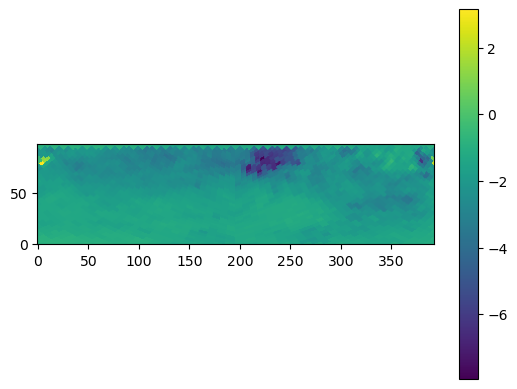

In [16]:
# torno in 2d

cmb_I_2d_1, _, _ = convert2grid(cmb_I_1, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
cmb_Q_2d_1, _, _ = convert2grid(cmb_Q_1, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
cmb_U_2d_1, _, _ = convert2grid(cmb_U_1, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)

cmb_I_2d_2, _, _ = convert2grid(cmb_I_2, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
cmb_Q_2d_2, _, _ = convert2grid(cmb_Q_2, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
cmb_U_2d_2, _, _ = convert2grid(cmb_U_2, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)

cmb_I_2d_3, _, _ = convert2grid(cmb_I_3, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
cmb_Q_2d_3, _, _ = convert2grid(cmb_Q_3, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
cmb_U_2d_3, _, _ = convert2grid(cmb_U_3, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)

plt.figure()
plt.imshow(cmb_I_2d_1,origin='lower')
plt.colorbar()

In [17]:
# PS


import pymaster as nmt

pix_size_rad = np.radians(pix_size /60)

X_width_rad = Nx * pix_size_rad
Y_width_rad = Ny * pix_size_rad


# Masks:
# Let's now create a mask:
mask = np.ones_like(cmb_I_2d_1)

# Bins:
l0_bins = np.arange(Nx) * 8 * np.pi/X_width_rad
lf_bins = (np.arange(Nx)+1) * 8 * np.pi/X_width_rad
b = nmt.NmtBinFlat(l0_bins, lf_bins)

# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled = b.get_effective_ells()


# Fields: per ogni mappa
# faccio i power spectra delle mappe ottenute dall'analisi, quindi TT, EE, BB per 3 angoli di polarizzazione

# angolo di pol 1
f0_1 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [cmb_I_2d_1])
f2_1 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [cmb_Q_2d_1, cmb_U_2d_1], purify_b=True)

# angolo di pol 2
f0_2 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [cmb_I_2d_2])
f2_2 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [cmb_Q_2d_2, cmb_U_2d_2], purify_b=True)


# angolo di pol 3
f0_3 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [cmb_I_2d_3])
f2_3 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [cmb_Q_2d_3, cmb_U_2d_3], purify_b=True)


In [18]:
# workspace (per ognuno!!)

# 1
w00_1 = nmt.NmtWorkspaceFlat()
w02_1 = nmt.NmtWorkspaceFlat()
w22_1 = nmt.NmtWorkspaceFlat()

w00_1.compute_coupling_matrix(f0_1, f0_1, b)
w02_1.compute_coupling_matrix(f0_1, f2_1, b)
w22_1.compute_coupling_matrix(f2_1, f2_1, b)

w00_1.write_to("w00_flat_1.fits")
w02_1.write_to("w02_flat_1.fits")
w22_1.write_to("w22_flat_1.fits")


# 2
w00_2 = nmt.NmtWorkspaceFlat()
w02_2 = nmt.NmtWorkspaceFlat()
w22_2 = nmt.NmtWorkspaceFlat()

w00_2.compute_coupling_matrix(f0_2, f0_2, b)
w02_2.compute_coupling_matrix(f0_2, f2_2, b)
w22_2.compute_coupling_matrix(f2_2, f2_2, b)

w00_2.write_to("w00_flat_2.fits")
w02_2.write_to("w02_flat_2.fits")
w22_2.write_to("w22_flat_2.fits")

# 3
w00_3 = nmt.NmtWorkspaceFlat()
w02_3 = nmt.NmtWorkspaceFlat()
w22_3 = nmt.NmtWorkspaceFlat()

w00_3.compute_coupling_matrix(f0_3, f0_3, b)
w02_3.compute_coupling_matrix(f0_3, f2_3, b)
w22_3.compute_coupling_matrix(f2_3, f2_3, b)

w00_3.write_to("w00_flat_3.fits")
w02_1.write_to("w02_flat_3.fits")
w22_3.write_to("w22_flat_3.fits")

In [19]:
# Computing power spectra:

# 1
cl00_coupled_1 = nmt.compute_coupled_cell_flat(f0_1, f0_1, b)
#cl00_uncoupled_1 = w00_1.decouple_cell(cl00_coupled_1)
cl02_coupled_1 = nmt.compute_coupled_cell_flat(f0_1, f2_1, b)
#cl02_uncoupled_1 = w02_1.decouple_cell(cl02_coupled_1)
cl22_coupled_1 = nmt.compute_coupled_cell_flat(f2_1, f2_1, b)
#cl22_uncoupled_1 = w22_1.decouple_cell(cl22_coupled_1)

# 2
cl00_coupled_2 = nmt.compute_coupled_cell_flat(f0_2, f0_2, b)
#cl00_uncoupled_2 = w00_2.decouple_cell(cl00_coupled_2)
cl02_coupled_2 = nmt.compute_coupled_cell_flat(f0_2, f2_2, b)
#cl02_uncoupled_2 = w02_2.decouple_cell(cl02_coupled_2)
cl22_coupled_2 = nmt.compute_coupled_cell_flat(f2_2, f2_2, b)
#cl22_uncoupled_2 = w22_2.decouple_cell(cl22_coupled_2)


# 3
cl00_coupled_3 = nmt.compute_coupled_cell_flat(f0_3, f0_3, b)
#cl00_uncoupled_3 = w00_3.decouple_cell(cl00_coupled_3)
cl02_coupled_3 = nmt.compute_coupled_cell_flat(f0_3, f2_3, b)
#cl02_uncoupled_3 = w02_3.decouple_cell(cl02_coupled_3)
cl22_coupled_3 = nmt.compute_coupled_cell_flat(f2_3, f2_3, b)
#cl22_uncoupled_3 = w22_3.decouple_cell(cl22_coupled_3)

<Figure size 640x480 with 0 Axes>

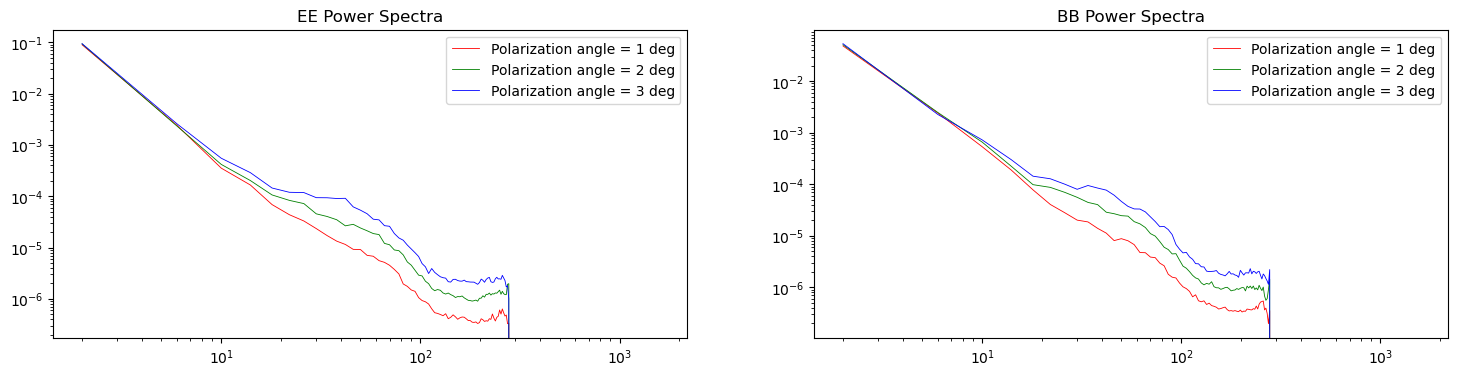

In [20]:
plt.figure()
fig, ax = plt.subplots(1,2, figsize = (18,4))


# EE
ax[0].set_title('EE Power Spectra')
ax[0].plot(ells_uncoupled, cl22_coupled_1[0], 'r', label='Polarization angle = 1 deg', linewidth=0.6)
ax[0].plot(ells_uncoupled, cl22_coupled_2[0], 'g', label='Polarization angle = 2 deg', linewidth=0.6)
ax[0].plot(ells_uncoupled, cl22_coupled_3[0], 'b', label='Polarization angle = 3 deg', linewidth=0.6)
ax[0].loglog()
ax[0].legend()

# BB
ax[1].set_title('BB Power Spectra')
ax[1].plot(ells_uncoupled, cl22_coupled_1[3], 'r', label='Polarization angle = 1 deg', linewidth=0.6)
ax[1].plot(ells_uncoupled, cl22_coupled_2[3], 'g', label='Polarization angle = 2 deg', linewidth=0.6)
ax[1].plot(ells_uncoupled, cl22_coupled_3[3], 'b', label='Polarization angle = 3 deg', linewidth=0.6)
ax[1].loglog()
ax[1].legend()


plt.show()

Effetto dei diversi angoli di polarizzazione sui PS di mappe di CMB (senza le altre componenti)

### Deconvoluzione

In [21]:
I_deconv_1 = deconvolve_map(cmb_I_2d_1, beam_x, perf_beam)
I_deconv_2 = deconvolve_map(cmb_I_2d_2, beam_x, perf_beam)
I_deconv_3 = deconvolve_map(cmb_I_2d_3, beam_x, perf_beam)

Q_deconv_1 = deconvolve_map(cmb_Q_2d_1, beam_x, perf_beam)
U_deconv_1 = deconvolve_map(cmb_U_2d_1, beam_x, perf_beam)

Q_deconv_2 = deconvolve_map(cmb_Q_2d_2, beam_x, perf_beam)
U_deconv_2 = deconvolve_map(cmb_U_2d_2, beam_x, perf_beam)

Q_deconv_3 = deconvolve_map(cmb_Q_2d_3, beam_x, perf_beam)
U_deconv_3 = deconvolve_map(cmb_U_2d_3, beam_x, perf_beam)

In [22]:
# convoluzione con beam perfetto
I_conv_perf_1 = convolve_map_with_beam(cmb_I_2d_1, perf_beam)
Q_conv_perf_1 = convolve_map_with_beam(cmb_Q_2d_1, perf_beam)
U_conv_perf_1 = convolve_map_with_beam(cmb_U_2d_1, perf_beam)

I_conv_perf_2 = convolve_map_with_beam(cmb_I_2d_2, perf_beam)
Q_conv_perf_2 = convolve_map_with_beam(cmb_Q_2d_2, perf_beam)
U_conv_perf_2 = convolve_map_with_beam(cmb_U_2d_2, perf_beam)

I_conv_perf_3 = convolve_map_with_beam(cmb_I_2d_3, perf_beam)
Q_conv_perf_3 = convolve_map_with_beam(cmb_Q_2d_3, perf_beam)
U_conv_perf_3 = convolve_map_with_beam(cmb_U_2d_3, perf_beam)

# DIFFERENCE
Q_diff_1 = (Q_conv_perf_1- Q_deconv_1)
U_diff_1 = (U_conv_perf_1- U_deconv_1)

Q_diff_2 = (Q_conv_perf_2- Q_deconv_2)
U_diff_2 = (U_conv_perf_2- U_deconv_2)

Q_diff_3 = (Q_conv_perf_3- Q_deconv_3)
U_diff_3 = (U_conv_perf_3- U_deconv_3)

# Original PS con CAMB

Voglio trovare r per ricavare il PS con CAMB. Voglio l'r della patch originale, prima del beam + pol ang. Ho mappe I,Q,U per 8 frequenze

In [23]:
freq40 = np.stack([I40, Q40, U40])
freq60 = np.stack([I60, Q60, U60])
freq78 = np.stack([I78, Q78, U78])
freq100 = np.stack([I100, Q100, U100])
freq140 = np.stack([I140, Q140, U140])
freq195 = np.stack([I195, Q195, U195])
freq280 = np.stack([I280, Q280, U280])
freq402 = np.stack([I402, Q402, U402])

full_array = np.array([freq40, freq60, freq78, freq100, freq140, freq195, freq280, freq402])

np.shape(full_array)

(8, 3, 49152)

In [24]:

np.shape(full_array)

(8, 3, 49152)

fsky =  0.052652994791666664
======= ESTIMATION OF SPECTRAL PARAMETERS =======
res.x =  [ 1.33464064 35.75170734 -2.62368279]
======= ESTIMATION OF NOISE AFTER COMP SEP =======
======= COMPUTATION OF CL_FGS =======
======= ESTIMATION OF STAT AND SYS RESIDUALS =======
======= OPTIMIZATION OF COSMO LIKELIHOOD =======
bounds on r =  0.07546672630843887  /  0.07903065678861348
starting point =  0.07722813571388643
    ===>> fitted r =  [0.07799764]
======= ESTIMATION OF SIGMA(R) =======
ind_sr_min =  0
sr_grid[ind_sr_min-1] =  [1.]
sr_grid[ind_sr_min+1] =  [0.08674505]
sr_grid =  [[0.07799764]
 [0.08674505]
 [0.09647349]
 [0.10729297]
 [0.11932585]
 [0.13270822]
 [0.14759141]
 [0.16414375]
 [0.18255244]
 [0.20302565]
 [0.22579493]
 [0.25111777]
 [0.27928057]
 [0.31060182]
 [0.34543574]
 [0.38417628]
 [0.42726155]
 [0.47517883]
 [0.52847003]
 [0.58773782]
 [0.65365247]
 [0.72695944]
 [0.80848777]
 [0.89915948]
 [1.        ]]
case # 1
bounds on sigma(r) =  [0.07799764]  /  [0.08674505]
start

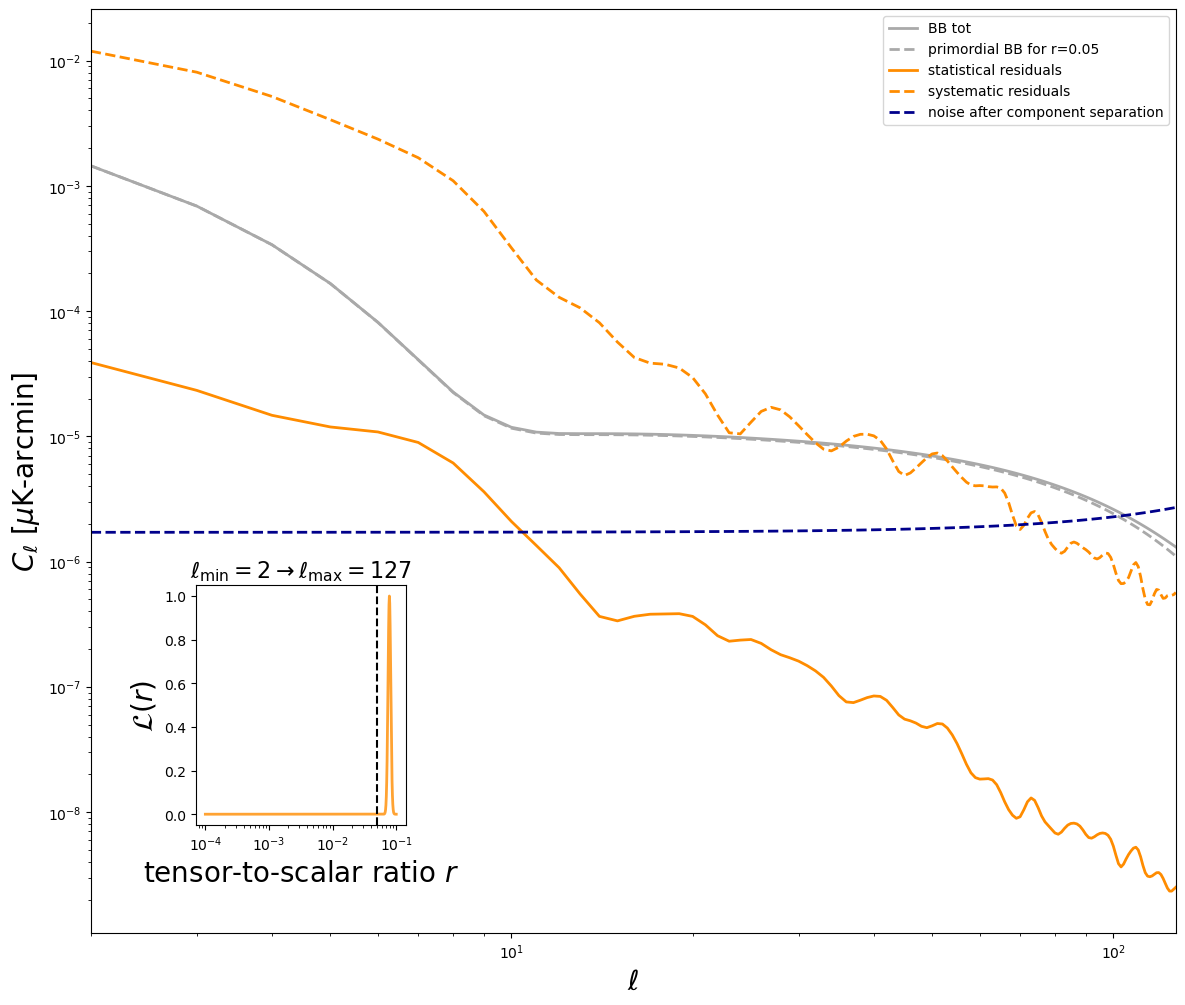

In [25]:
from fgbuster import xForecast, CMB, Dust, Synchrotron

components = [CMB(), Dust(350.), Synchrotron(20.)]

instrument = get_instrument('LiteBIRD')

res = xForecast(components, freq, full_array, 2, 2*nside-1, Alens=0.1, r=0.05, make_figure=True)

In [26]:
r = 0.07799764

pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=r)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
pars.WantTensors= True

results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')


totCL = powers['total']
unlensedCL = powers['unlensed_scalar']
tensor = powers['tensor']

ls = np.arange(totCL.shape[0])


<Figure size 640x480 with 0 Axes>

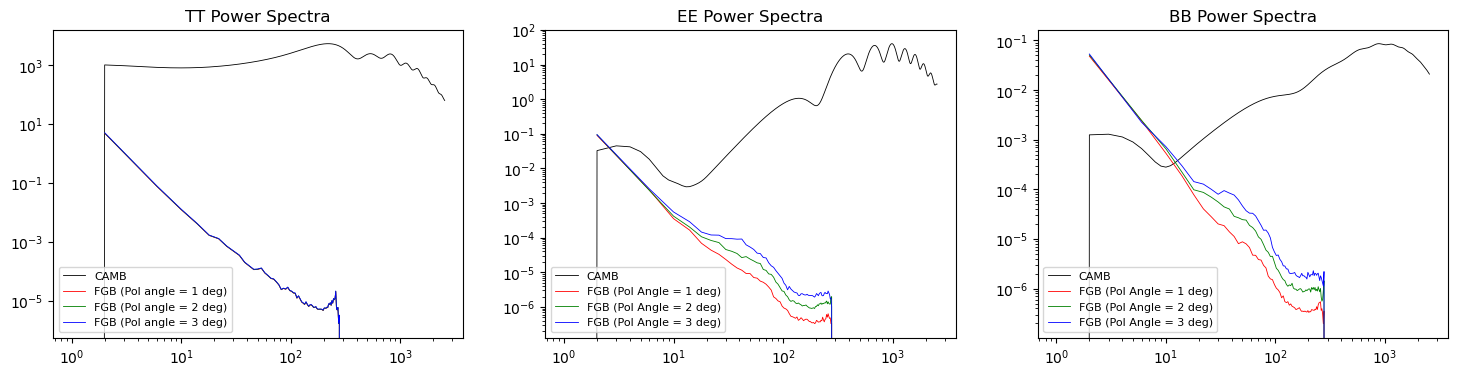

In [27]:
plt.figure()
fig, ax = plt.subplots(1,3, figsize = (18,4))

# TT
ax[0].set_title('TT Power Spectra')
ax[0].plot(ls,totCL[:,0], color='k', label='CAMB', linewidth=0.6)

ax[0].plot(ells_uncoupled, cl00_coupled_1[0], 'r', label='FGB (Pol angle = 1 deg)', linewidth=0.6)
ax[0].plot(ells_uncoupled, cl00_coupled_2[0], 'g', label='FGB (Pol angle = 2 deg)', linewidth=0.6)
ax[0].plot(ells_uncoupled, cl00_coupled_3[0], 'b', label='FGB (Pol angle = 3 deg)', linewidth=0.6)
ax[0].loglog()
ax[0].legend(fontsize=8, loc='lower left')

# EE
ax[1].set_title('EE Power Spectra')
ax[1].plot(ls,totCL[:,1], color='k', label='CAMB', linewidth=0.6)

ax[1].plot(ells_uncoupled, cl22_coupled_1[0], 'r', label='FGB (Pol Angle = 1 deg)', linewidth=0.6)
ax[1].plot(ells_uncoupled, cl22_coupled_2[0], 'g', label='FGB (Pol Angle = 2 deg)', linewidth=0.6)
ax[1].plot(ells_uncoupled, cl22_coupled_3[0], 'b', label='FGB (Pol Angle = 3 deg)', linewidth=0.6)
ax[1].loglog()
ax[1].legend(fontsize=8, loc='lower left')

# BB
ax[2].set_title('BB Power Spectra')
ax[2].plot(ls,totCL[:,2], color='k', label='CAMB', linewidth=0.6)

ax[2].plot(ells_uncoupled, cl22_coupled_1[3], 'r', label='FGB (Pol Angle = 1 deg)', linewidth=0.6)
ax[2].plot(ells_uncoupled, cl22_coupled_2[3], 'g', label='FGB (Pol Angle = 2 deg)', linewidth=0.6)
ax[2].plot(ells_uncoupled, cl22_coupled_3[3], 'b', label='FGB (Pol Angle = 3 deg)', linewidth=0.6)
ax[2].loglog()
ax[2].legend(fontsize=8, loc='lower left')


plt.show()

Confronto dei grafici di prima con il PS trovato con l'r trovato da FGB dalle patch originali (prima non avevo rappresentato TT perchè in realtà l'angolo di polarizzazione non si applica a TT, quindi sono tutti uguali. Ho comunque 3 spettri TT perchè derivano da 3 mappe di cmb. Quando faccio la component separation devo infatti dare I, Q, U e trovo la cmb. I è uguale per tutti gli angoli, cambiano Q e U, quindi ho 3 mappe di cmb diverse)

# Grafici di confronto - mappe
Confronto 
- mappa originale (cmb_Q_2d), convoluta con beam(Q_conv_real), angolo di polarizzazione (1 a caso)(Q_polangle_1), apodizzata(Q_ap_1), deconvoluta(Q_deconv_1) e differenza(Q_diff_1) 
- convoluta con beam(Q_conv_real), angolo di polarizzazione (tutte)(Q_polangle_1), deconvoluta(Q_deconv_1) e differenza(Q_diff_1) 


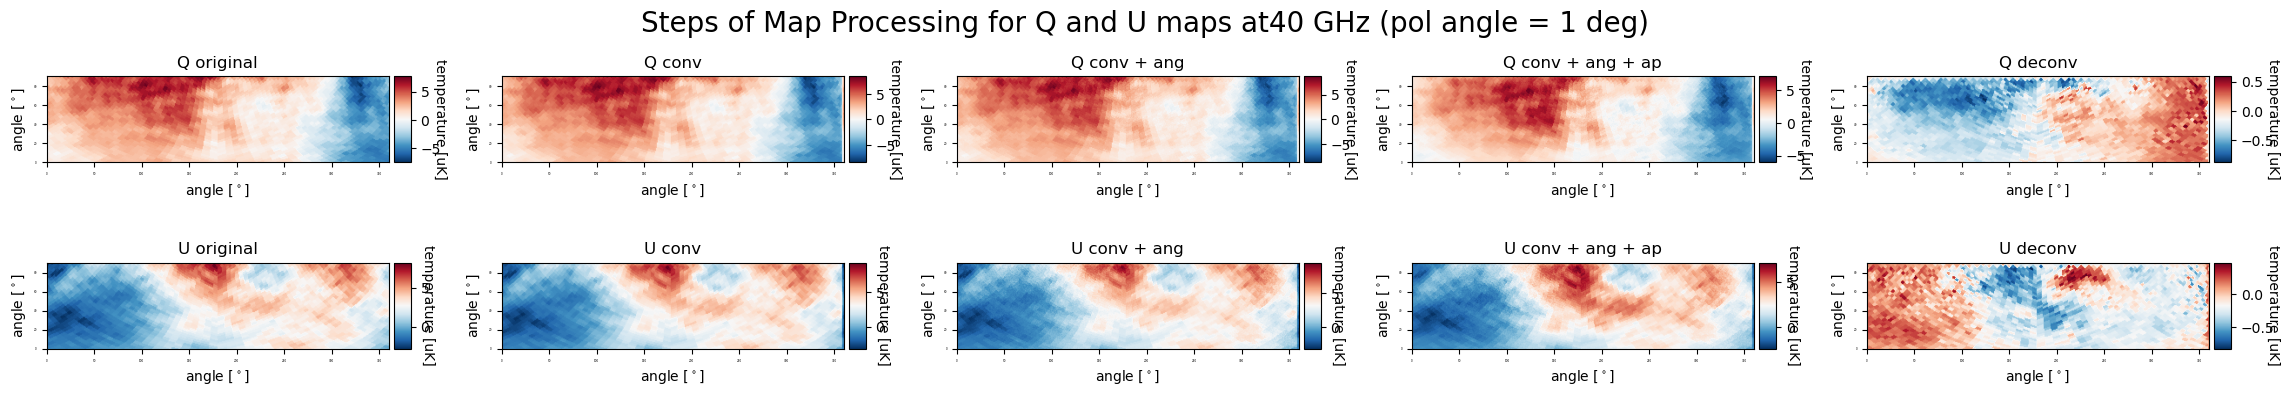

In [28]:
Map_to_Plot = [maps_2d['mp_hp_Q40'] , Q_conv_real_40, Q_pert40_1, Q_ap40_1, Q_deconv_1 ,
               maps_2d['mp_hp_U40'] , U_conv_real_40, U_pert40_1, U_ap40_1, U_deconv_1]

title = ["Q original", "Q conv", "Q conv + ang", "Q conv + ang + ap", "Q deconv",
         "U original", "U conv", "U conv + ang", "U conv + ang + ap", "U deconv"]

c_factor_max = np.zeros(len(Map_to_Plot))
c_factor_min = np.zeros(len(Map_to_Plot))

for i in range (len(Map_to_Plot)):
    c_factor_max[i] = np.max(Map_to_Plot[i])
    c_factor_min[i] = np.min(Map_to_Plot[i])


fig, axs = plt.subplots(2, 5, figsize=(23, 4))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width)
        axs[i].set_title(title[i])
        axs[i].tick_params(axis='both', which='major', labelsize=2)

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle('Steps of Map Processing for Q and U maps at40 GHz (pol angle = 1 deg)', fontsize=20)
plt.show()

I vari passaggi per una sola frequenza e un solo angolo di polarizzazione (la deconvoluzione si fa dopo la component separation. le patch in figura contengono tutto, le patch deconvolute solo la cmb)

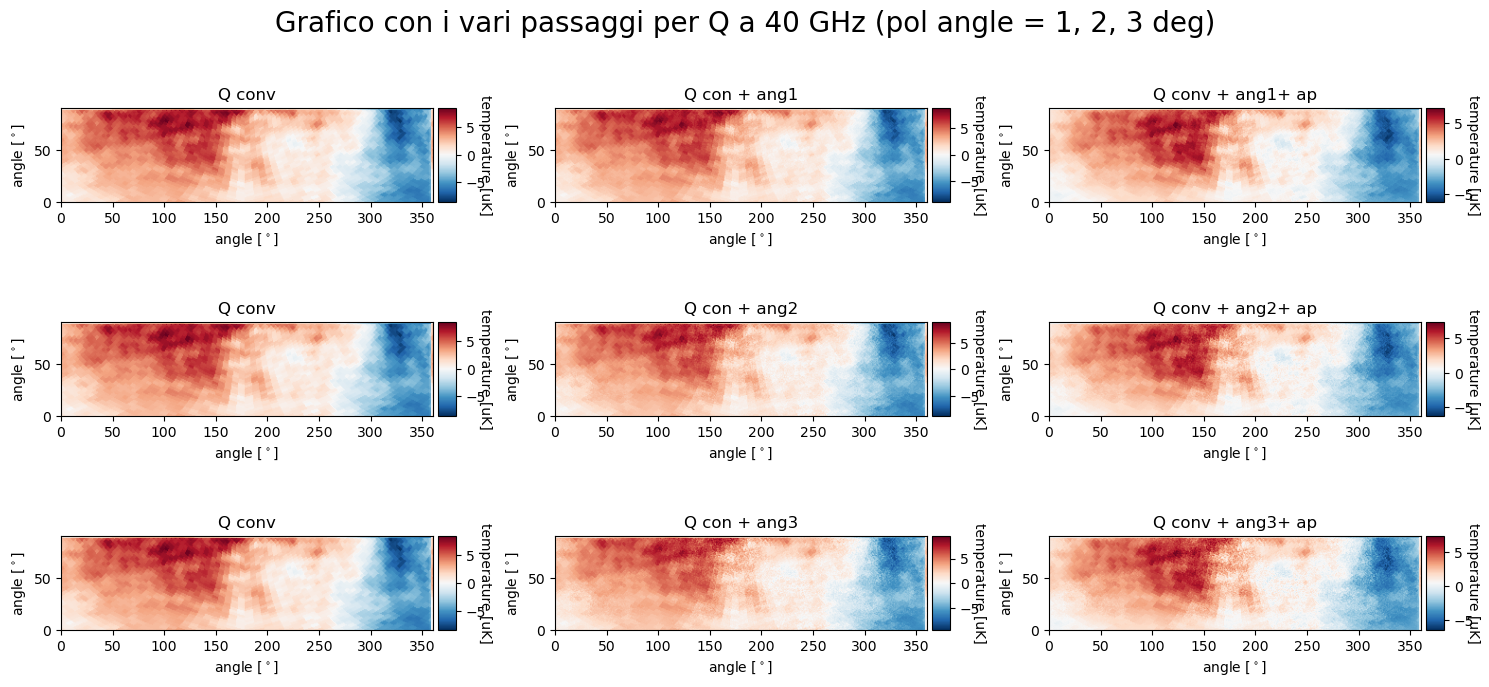

In [29]:
Map_to_Plot = [Q_conv_real_40, Q_pert40_1 ,Q_ap40_1, 
               Q_conv_real_40, Q_pert40_2 ,Q_ap40_2, 
               Q_conv_real_40, Q_pert40_3 ,Q_ap40_3 ]
title = ["Q conv", "Q con + ang1",  "Q conv + ang1+ ap",
         "Q conv", "Q con + ang2",  "Q conv + ang2+ ap",
         "Q conv", "Q con + ang3",  "Q conv + ang3+ ap"]

c_factor_max = np.zeros(len(Map_to_Plot))
c_factor_min = np.zeros(len(Map_to_Plot))

for i in range (len(Map_to_Plot)):
    c_factor_max[i] = np.max(Map_to_Plot[i])
    c_factor_min[i] = np.min(Map_to_Plot[i])


fig, axs = plt.subplots(3, 3, figsize=(15, 7))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle('Grafico con i vari passaggi per Q a 40 GHz (pol angle = 1, 2, 3 deg)', fontsize=20)
plt.show()

Solo mappe Q e solo alla frequenza 40 GHz. La prima colonna mostra la stessa mappa, dopo la convoluzione con il beam. La seconda colonna mostra l'aggiunta dell'angolo di polarizzazione, con i 3 diversi angoli. La terza colonna mostra l'apodizzazione 